In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

from sklearn.cluster import KMeans
#from sklearn.cluster import AgglomerativeClustering

import scipy.stats as scy

from statsmodels.api import OLS # Pour la régression linéaire (avec statsmodels)
from statsmodels.tools.tools import add_constant # Pour l'ajout d'une constante dans statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression # Pour la régression linéaire (avec sklearn)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error # Pour les critères d'erreur
import statsmodels.api as sm
import itertools 
#from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import train_test_split


Data

In [2]:
data = pd.read_csv('concrete_compressive_strength.csv', delimiter=';', decimal=',')

data.head()


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


*Exercice 1 - Analyse exploratoire*

*Question 1.1*

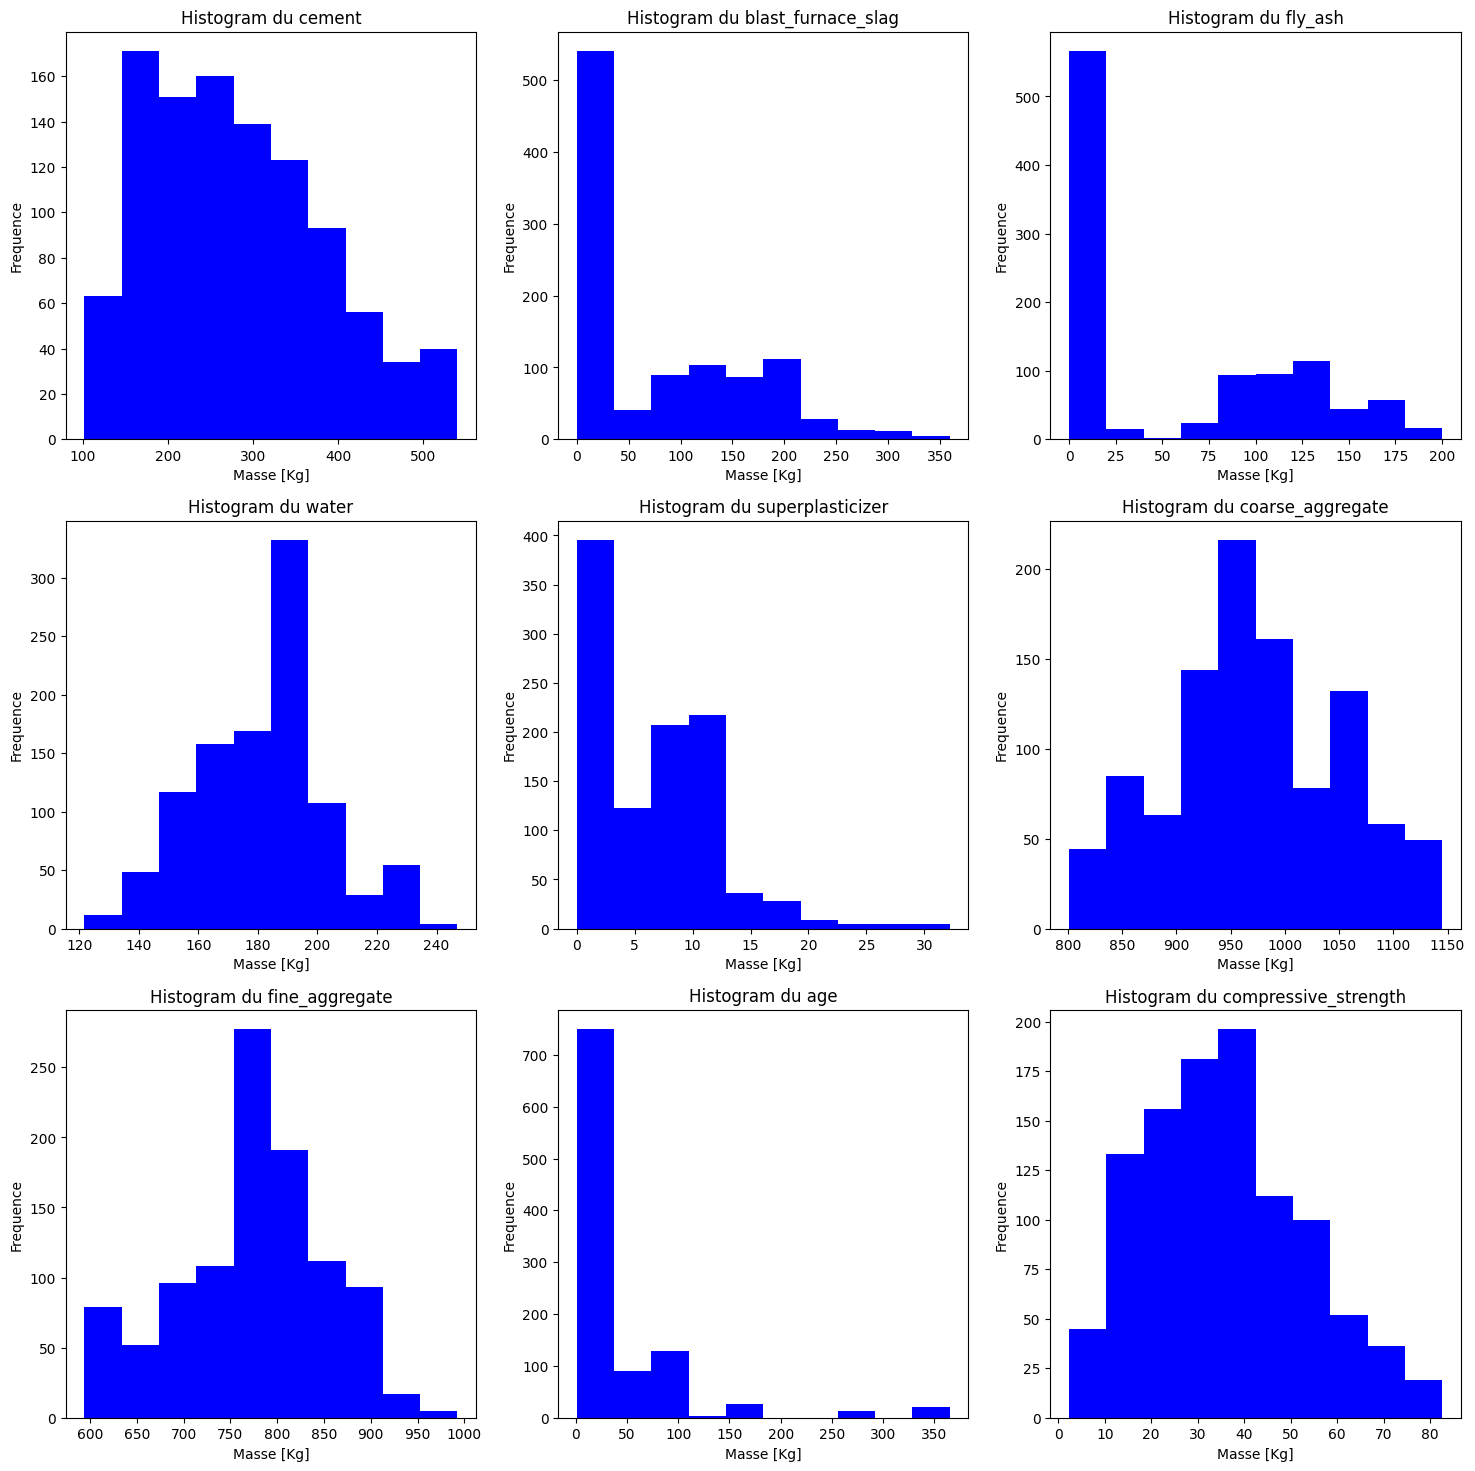

In [ ]:
# histograms



colums = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 
           'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength']

plt.figure(figsize=(18,18))

for i, col in enumerate(colums, 1):

    plt.subplot(3, 3, i)
    
    plt.hist(data[col], color='blue')
    plt.title(f'Histogram du {col}')
    plt.xlabel('Masse [Kg]')
    plt.ylabel('Frequence')

plt.show()

In [4]:
# resumés numerics

numerical_summaries = data.describe()
numerical_summaries.head(10)

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


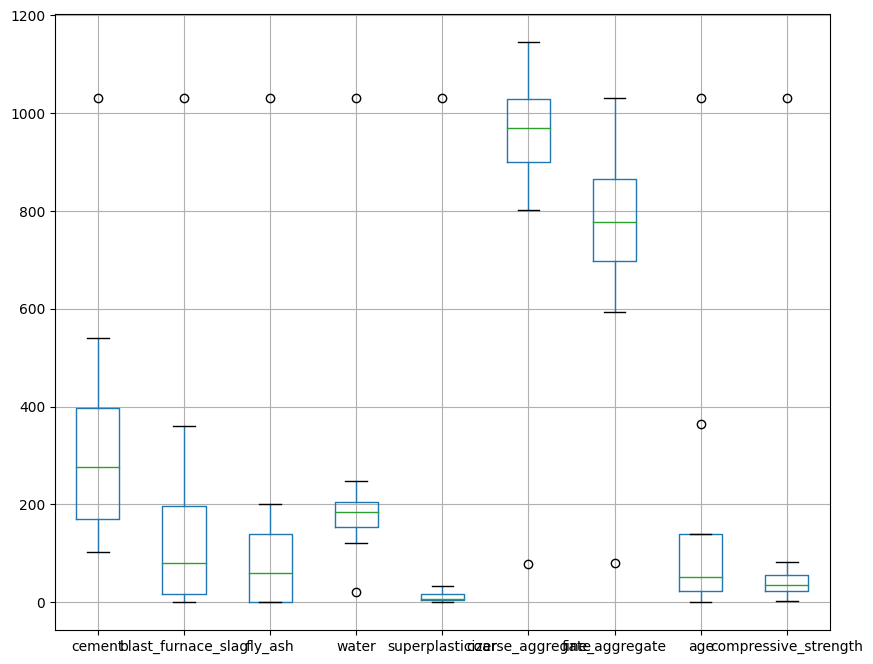

In [5]:

numerical_summaries.boxplot(figsize=(10,8))
plt.show()

*Question 1.2*

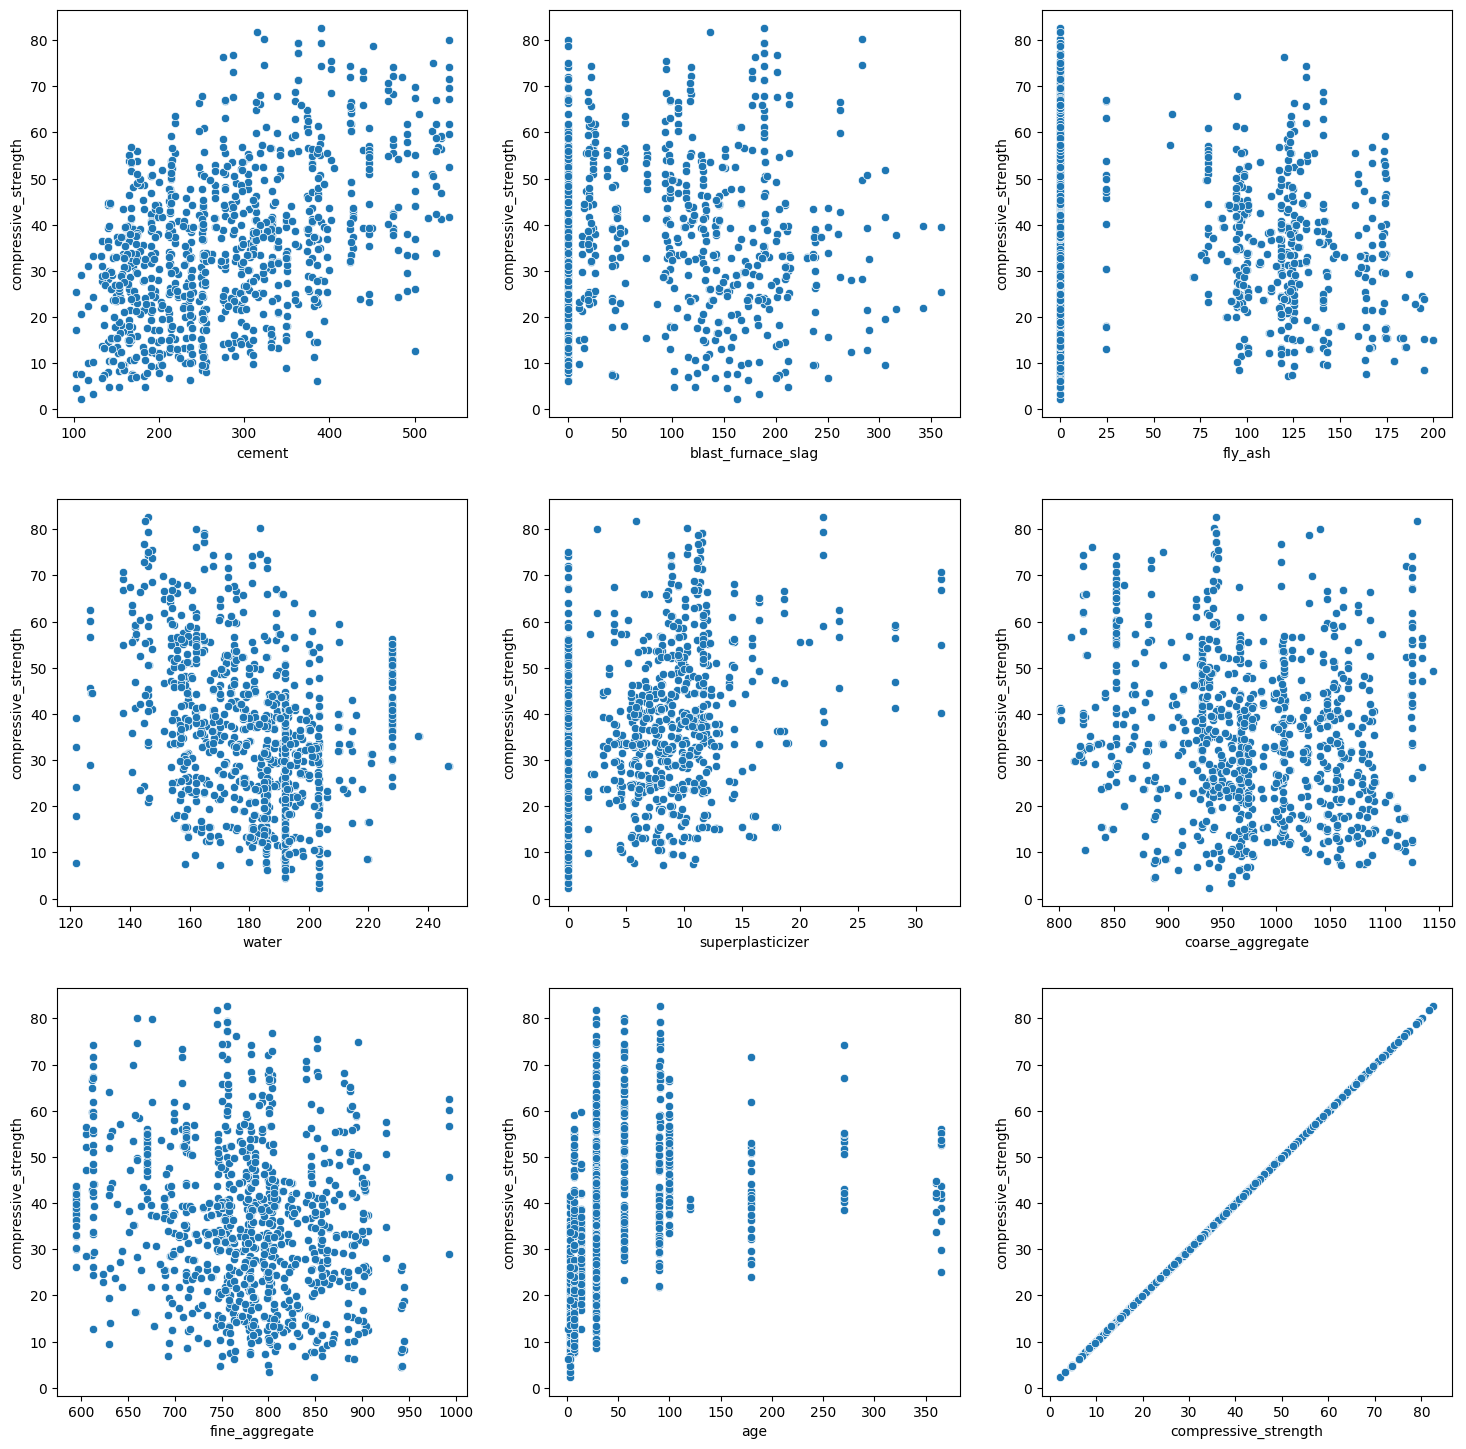

In [6]:
# nuages de points de la rèsistance à la compression du béton en fonction des 8 covariables

plt.figure(figsize=(18,18))

for i, var in enumerate(colums,1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=data, x=var, y='compressive_strength')
    


plt.show()

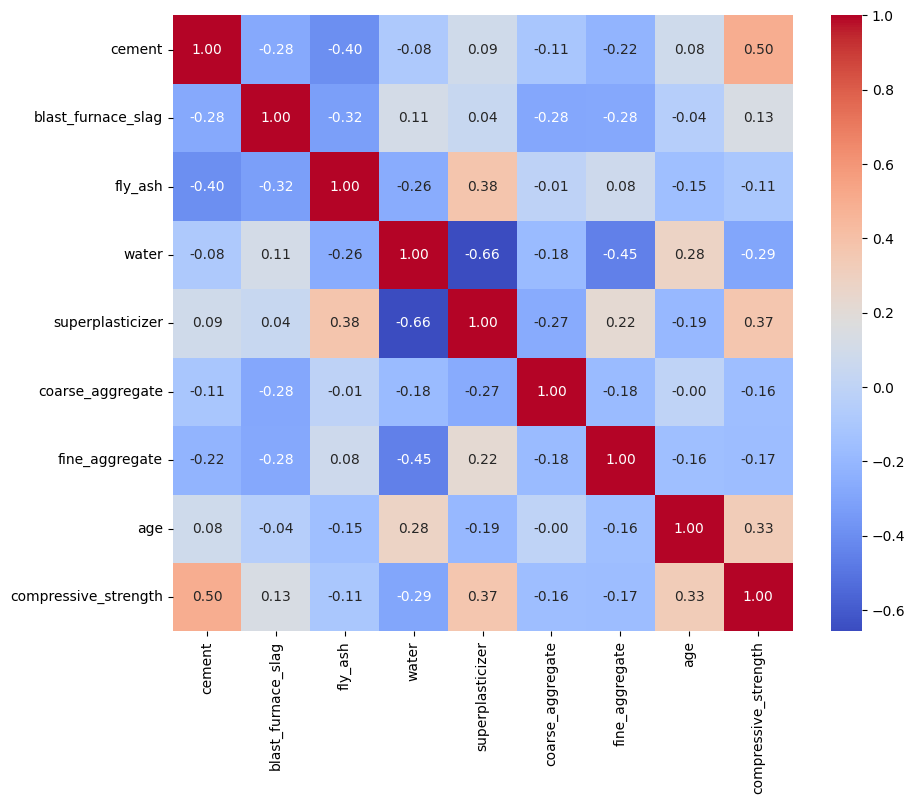

In [7]:
# matrix correlation

correlation_matrix = data.corr()
correlation_matrix.head(10)
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm', fmt=".2f")
plt.show()

*Question 1.3*

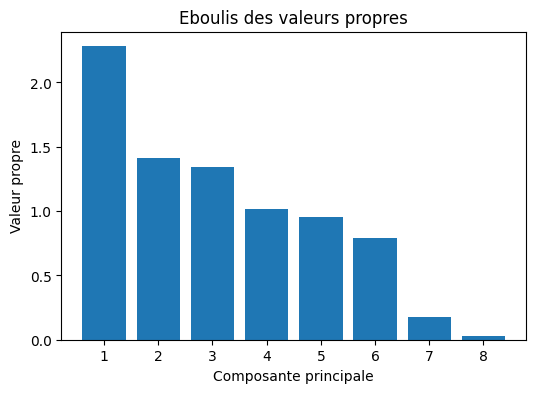

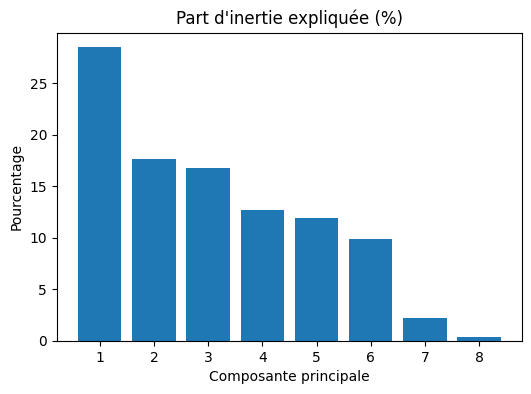

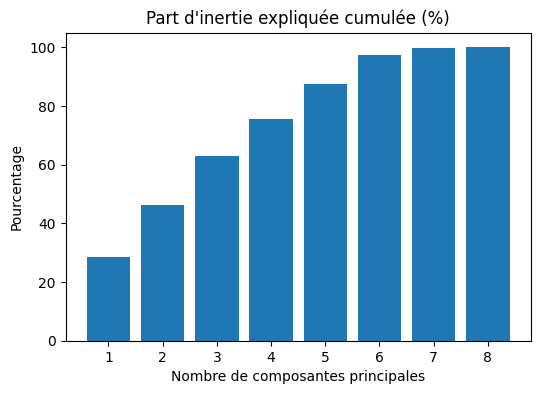

(PCA(svd_solver='full'),
       cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
 0      540.0                 0.0      0.0  162.0               2.5   
 1      540.0                 0.0      0.0  162.0               2.5   
 2      332.5               142.5      0.0  228.0               0.0   
 3      332.5               142.5      0.0  228.0               0.0   
 4      198.6               132.4      0.0  192.0               0.0   
 ...      ...                 ...      ...    ...               ...   
 1025   276.4               116.0     90.3  179.6               8.9   
 1026   322.2                 0.0    115.6  196.0              10.4   
 1027   148.5               139.4    108.6  192.7               6.1   
 1028   159.1               186.7      0.0  175.6              11.3   
 1029   260.9               100.5     78.3  200.6               8.6   
 
       coarse_aggregate  fine_aggregate  age      CP_1      CP_2  ...  \
 0               1040.0           676.0   28  0.

In [8]:
def ACP_fonc(data_acp,
             inerties='non', n_cp=10, ech_iner_x=6, ech_iner_y=4,
             cercle='non', ech_cer=8,
             projection='non', label_indiv='non', ech_pr_x=5, ech_pr_y=4,
             cp_x=1, cp_y=2):
    
    n = data_acp.shape[0]
    p = data_acp.shape[1]
    n_cp = min(n_cp, p)
    
    norm = StandardScaler(with_mean=True, with_std=True)
    data_acp_norm = norm.fit_transform(data_acp)

    acp_model = decomposition.PCA(svd_solver='full')
    acp_out = acp_model.fit(data_acp_norm)

    val_prop = (n-1)/n * acp_out.explained_variance_
    part_inertie_expl = acp_out.explained_variance_ratio_

    if inerties == 'oui':
        plt.subplots(figsize=(ech_iner_x, ech_iner_y))
        plt.bar(np.arange(1, n_cp+1), val_prop)
        #plt.grid()
        plt.title('Eboulis des valeurs propres')
        plt.xlabel('Composante principale')
        plt.ylabel('Valeur propre')
        plt.show()

        plt.subplots(figsize=(ech_iner_x, ech_iner_y))
        plt.bar(np.arange(1, n_cp+1), val_prop/np.sum(val_prop)*100)
        #plt.grid()
        plt.title("Part d'inertie expliquée (%)")
        plt.xlabel('Composante principale')
        plt.ylabel('Pourcentage')
        plt.show()

        plt.subplots(figsize=(ech_iner_x, ech_iner_y))
        plt.bar(np.arange(1, n_cp+1), np.cumsum(part_inertie_expl)*100)
        #plt.grid()
        plt.title("Part d'inertie expliquée cumulée (%)")
        plt.xlabel('Nombre de composantes principales')
        plt.ylabel('Pourcentage')
        plt.show()
    
    coord = acp_out.fit_transform(data_acp_norm)
    data_acp_out = data_acp.copy()
    
    for i in range(p):
        data_acp_out['CP_'+str(i+1)] = coord[:,i]
    
    cos2 = coord**2
    for i in range(p):
        data_acp_out['Cos2_'+str(i+1)] = cos2[:,i] / np.sum(data_acp_norm**2,axis=1)
    
    ctr = coord**2
    for i in range(p):
        data_acp_out['CTR_'+str(i+1)] = ctr[:,i] / (n*val_prop[i])
    
    if cercle == 'oui':
        cor_var = np.zeros((p, p))
        for i in range(p):
            cor_var[:,i] = acp_out.components_[i,:] * np.sqrt((n-1)/n * acp_out.explained_variance_)[i]
        an = np.linspace(0, 2*np.pi, 100)
        fig, ax = plt.subplots(figsize=(ech_cer, ech_cer))
        for i in range(p):
            ax.arrow(0,
                     0,
                     cor_var[i, cp_x-1],
                     cor_var[i, cp_y-1],
                     head_width=0.03,
                     head_length=0.03,
                     length_includes_head=True) 
            ax.text(cor_var[i, cp_x-1]+0.01,
                     cor_var[i, cp_y-1],
                     data_acp.columns.values[i],
                     c='red')
        ax.plot(np.cos(an), np.sin(an))
        ax.axhline(y=0)
        ax.axvline(x=0)
        ax.axis('equal')
        ax.set_xlabel('CP {}'.format(cp_x))
        ax.set_ylabel('CP {}'.format(cp_y))
        ax.set_title('Cercle de corrélations')
        plt.show()
    
    if projection == 'oui':
        fig, ax = plt.subplots(figsize=(2*ech_pr_x, 2*ech_pr_y))
        ax.set_xlim(-ech_pr_x, ech_pr_y)
        ax.set_ylim(-ech_pr_x, ech_pr_y)
        ax.scatter(data_acp_out['CP_'+str(cp_x)], data_acp_out['CP_'+str(cp_y)], s=40)
        ax.axhline(y=0)
        ax.axvline(x=0)
        ax.set_xlabel('CP {}'.format(cp_x))
        ax.set_ylabel('CP {}'.format(cp_y))
        ax.set_title('Projection des individus')
        if label_indiv == 'oui':
            for i in range(n):
                ax.annotate(data_acp.index[i], (data_acp_out['CP_'+str(cp_x)].iloc[i]+0.1, data_acp_out['CP_'+str(cp_y)].iloc[i]+0.1))
        plt.show()
    
    return acp_out, data_acp_out


# ACP
data_acp= data.drop(['compressive_strength'], axis=1)
acp_out, data_acp_out = ACP_fonc(data_acp=data_acp)
ACP_fonc(data_acp=data_acp, inerties='oui')

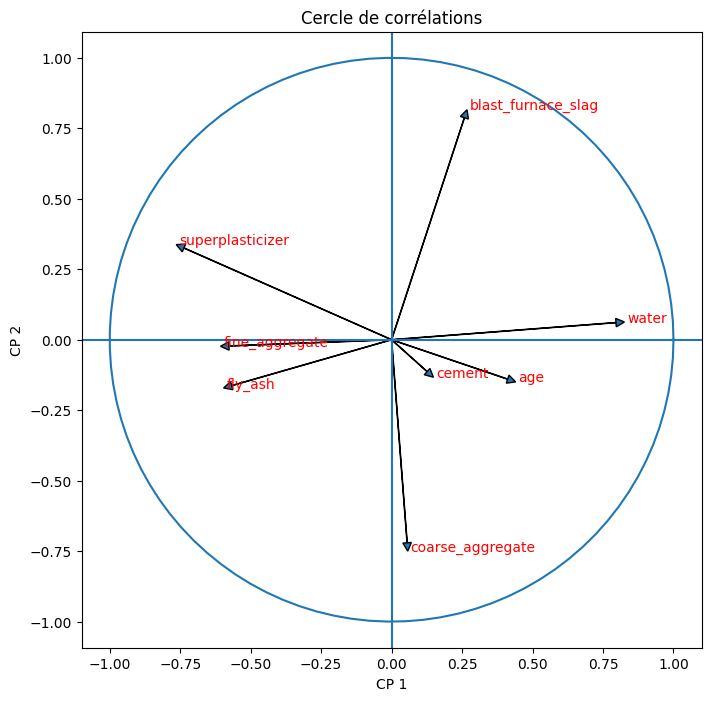

(PCA(svd_solver='full'),
       cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
 0      540.0                 0.0      0.0  162.0               2.5   
 1      540.0                 0.0      0.0  162.0               2.5   
 2      332.5               142.5      0.0  228.0               0.0   
 3      332.5               142.5      0.0  228.0               0.0   
 4      198.6               132.4      0.0  192.0               0.0   
 ...      ...                 ...      ...    ...               ...   
 1025   276.4               116.0     90.3  179.6               8.9   
 1026   322.2                 0.0    115.6  196.0              10.4   
 1027   148.5               139.4    108.6  192.7               6.1   
 1028   159.1               186.7      0.0  175.6              11.3   
 1029   260.9               100.5     78.3  200.6               8.6   
 
       coarse_aggregate  fine_aggregate  age      CP_1      CP_2  ...  \
 0               1040.0           676.0   28  0.

In [9]:
#circle des corrélations
ACP_fonc(data_acp=data_acp, cercle='oui', cp_x=1, cp_y=2)

## PERGUNTAR AO PROFESSOR SE PRECISA DO GRÁFICO DE PROJEÇÃO INDIVIDUAL

*Question 1.4*

In [10]:
# clustering escolhido (justificar pela minimização da variancia intra-cluster)
# def: agrupa dados em K clusters, onde K é predefinido.
# desvantagem: sensivèl à escolha inicial dos centroides e há presençad e outliers.
#vantagem: simples e eficiente.

# data without compressive_strength
data_cluster = data_acp

# on choisit 3 clusters
k = 4

# Para escolher o menor valor de k que seja aceitável, geralmente se utiliza 
# o "método do cotovelo" (elbow method). Esse método busca identificar um ponto 
# onde a redução na inércia intra-classe (variância interna) diminui drasticamente ao aumentar
# O gráfico mostra que a inércia intra-classe cai rapidamente entre k=2 e k=4, mas a partir de 
# 𝐾=4,K=4 a redução se torna menos significativa. Assim, o menor valor aceitável de 𝐾
# K seria 𝐾=4, pois, além desse ponto, o ganho ao aumentar 𝐾 é pequeno em comparação à redução inicial.

kmeans_model = KMeans(init='k-means++', max_iter=100, n_clusters=k, n_init=10)
kmeans = kmeans_model.fit(data_cluster)

data['cluster_kmeans'] = kmeans.fit_predict(data_cluster)
data['cluster_kmeans'].value_counts()

cluster_kmeans
1    337
0    274
3    239
2    180
Name: count, dtype: int64

In [11]:
k_max = 10

inertie_intra = pd.DataFrame(columns=['k', 'inertie_intra'])

for k in range(1, k_max+1):
    kmeans_model = KMeans(init='k-means++', max_iter=100, n_clusters=k, n_init=10)
    kmeans = kmeans_model.fit(data_cluster)
    inertie_intra.loc[k-1,'k'] = k
    inertie_intra.loc[k-1,'inertie_intra'] = kmeans.inertia_

inertie_intra['part_inertie_intra'] = inertie_intra['inertie_intra'] / inertie_intra['inertie_intra'][0]

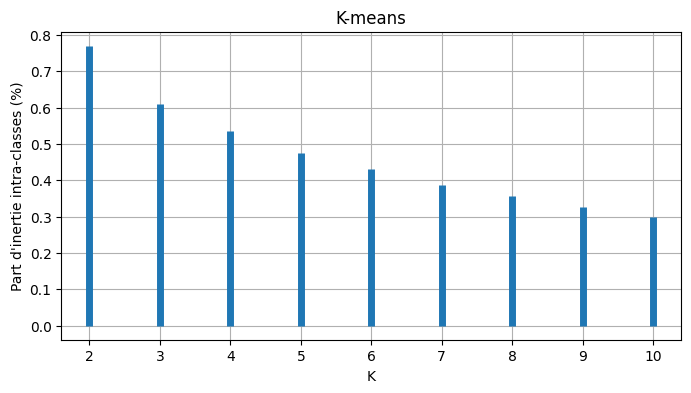

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(inertie_intra.iloc[1:]['k'], 0, inertie_intra.iloc[1:]['part_inertie_intra'], linewidth=5)
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel("Part d'inertie intra-classes (%)")
plt.title('K-means')
plt.show()

*Exercice 2 - Statistique décisionnelle*

In [13]:
# fly ash = zero

data_flyash_zero = data[['fly_ash','compressive_strength']]
data_flyash_zero = data_flyash_zero[data_flyash_zero['fly_ash']==0]

# fly ash =! zero

data_flyash_no_zero = data[['fly_ash','compressive_strength']]
data_flyash_no_zero = data_flyash_no_zero[data_flyash_no_zero['fly_ash']!=0]


# teste estatistico de igualdade de variancias

n_flyash_zero = len(data_flyash_zero['compressive_strength'])
sigma2_flyash_zero = data_flyash_zero['compressive_strength'].var()

n_flyash_no_zero = len(data_flyash_no_zero['compressive_strength'])
sigma2_flyash_no_zero =data_flyash_no_zero['compressive_strength'].var()

# teste de Fisher
stat = sigma2_flyash_zero / sigma2_flyash_no_zero
pval = 2 * min((1-scy.f.cdf(stat, dfn=n_flyash_zero-1, dfd=n_flyash_no_zero-1)), scy.f.cdf(stat, dfn=n_flyash_zero-1, dfd=n_flyash_no_zero-1))
print('p-valeur :', round(pval, ndigits=3))

# teste de Bartlett (generalização de Fisher)
stat, pval = scy.bartlett(data_flyash_zero['compressive_strength'], data_flyash_no_zero['compressive_strength'])
print('p-valeur :', round(pval, ndigits=3))

# teste de Levene (menos sensivel à hipótese de normalidade que os outros)
stat, pval = scy.levene(data_flyash_zero['compressive_strength'], data_flyash_no_zero['compressive_strength'])
print('p-valeur :', round(pval, ndigits=3))

# Conclusão: devemos rejeitar a hipótese nula, ou seja, 
# podemos afirmar que as variancias são diferentes com uma confiança de 95%

# Não podemos realizar o teste estatístico t de student, 
# pois os testes de variancias deram todos iguais a zero
# utilizaremos o teste de Welch para comparação das médias


# teste estatistico de igualdade das médias (teste de Welch) 
stat, pval = scy.ttest_ind(data_flyash_zero['compressive_strength'], data_flyash_no_zero['compressive_strength'], equal_var=False, alternative='two-sided')
print('p-valeur :', round(pval, ndigits=3))

# Conclusão: aceitamos a hipotese nula pois o p-value é menor do que 5%
# H_0 : medias iguais 
# ou seja, meio que a resistencia do concreto nao depende desse fly ash - pesquisar se isso faz sentido  hehe

p-valeur : 0.0
p-valeur : 0.0
p-valeur : 0.0
p-valeur : 0.038


*Exercice 3 - Régression*

*Question 3.1*

In [14]:
# regressao liner multipla

var_y = 'compressive_strength'
y = data[var_y]

var_x = ['cement','blast_furnace_slag','fly_ash', 'water', 'superplasticizer','coarse_aggregate', 'fine_aggregate', 'age']
X = data[var_x]


# linreg_comp_model = OLS(y, add_constant(X))
# linreg_comp = linreg_comp_model.fit()
# linreg_comp.summary()



linreg_sel_model = OLS(y, add_constant(X))
linreg_sel = linreg_sel_model.fit()
linreg_sel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     compressive_strength   R-squared:                       0.615
Model:                              OLS   Adj. R-squared:                  0.612
Method:                   Least Squares   F-statistic:                     204.3
Date:                  Thu, 14 Nov 2024   Prob (F-statistic):          6.76e-206
Time:                          20:22:28   Log-Likelihood:                -3869.0
No. Observations:                  1030   AIC:                             7756.
Df Residuals:                      1021   BIC:                             7800.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -23.1638     26.588     -0.871      0.384     -75.338      29.010
cement                 0.1198      0.008     14.110      0.000       0.103       0.136
blast_furnace_slag     0.1038      0.010     10.245      0.000       0.084       0.124
fly_ash                0.0879      0.013      6.988      0.000       0.063       0.113
water                 -0.1503      0.040     -3.741      0.000      -0.229      -0.071
superplasticizer       0.2907      0.093      3.110      0.002       0.107       0.474
coarse_aggregate       0.0180      0.009      1.919      0.055      -0.000       0.036
fine_aggregate         0.0202      0.011      1.883      0.060      -0.001       0.041
age                    0.1142      0.005     21.046      0.000       0.104       0.125
==============================================================================
Omnibus:                        5.379   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.305
Skew:                          -0.174   Prob(JB):                       0.0705
Kurtosis:                       3.045   Cond. No.                     1.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

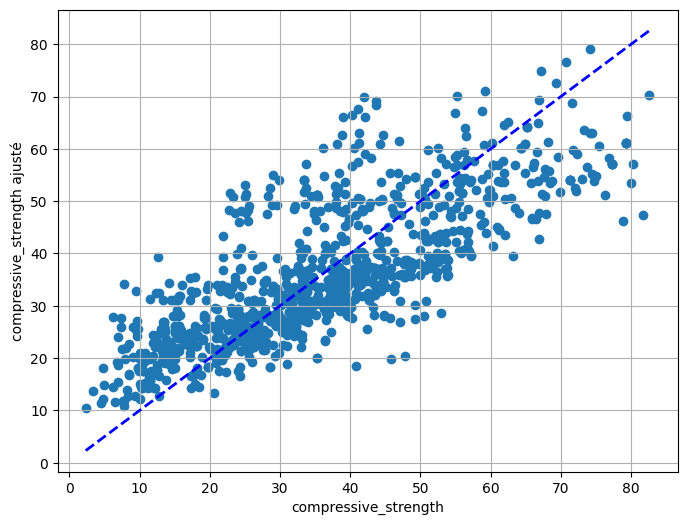

In [15]:
# analyse de l'ajustement
data['compressive_strength_ajust'] = linreg_sel.fittedvalues

x_bissec = np.linspace(data['compressive_strength'].min(), data['compressive_strength'].max(), 2)

plt.subplots(figsize=(8, 6))
plt.scatter(data['compressive_strength'], data['compressive_strength_ajust'])
plt.plot(x_bissec, x_bissec, linestyle='dashed', lw=2, color='blue')
plt.grid()
plt.xlabel('compressive_strength')
plt.ylabel('compressive_strength ajusté')
plt.show()

Moyenne des résidus : -0.0
Variance des résidus : 107.32


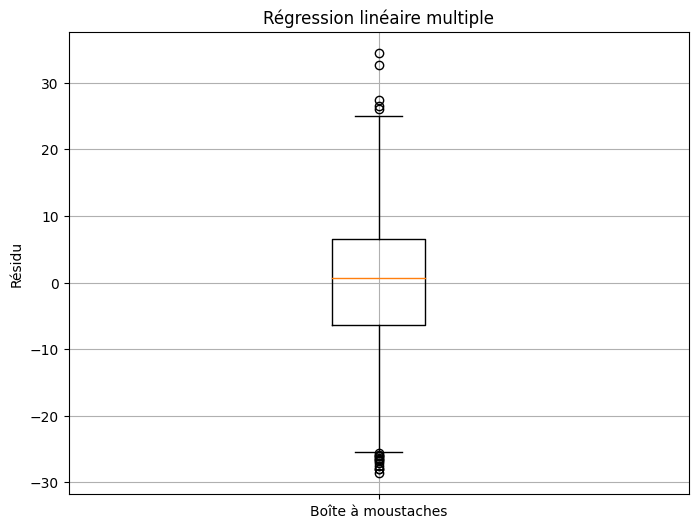

In [16]:
data['residu'] = linreg_sel.resid

moy_res = data.residu.mean()
print('Moyenne des résidus :', round(moy_res, ndigits=2))

var_res = data.residu.var()
print('Variance des résidus :', round(var_res, ndigits=2))

plt.subplots(figsize=(8, 6))
plt.boxplot(data['residu'], labels=['Boîte à moustaches'])
plt.grid()
plt.ylabel('Résidu')
plt.title('Régression linéaire multiple')
plt.show()

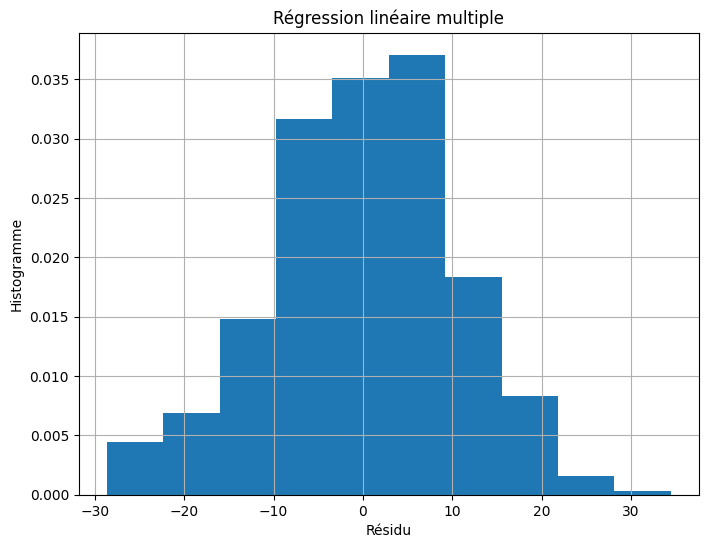

In [17]:
plt.subplots(figsize=(8, 6))
plt.hist(data['residu'], density=True)
plt.grid()
plt.xlabel('Résidu')
plt.ylabel('Histogramme')
plt.title('Régression linéaire multiple')
plt.show()

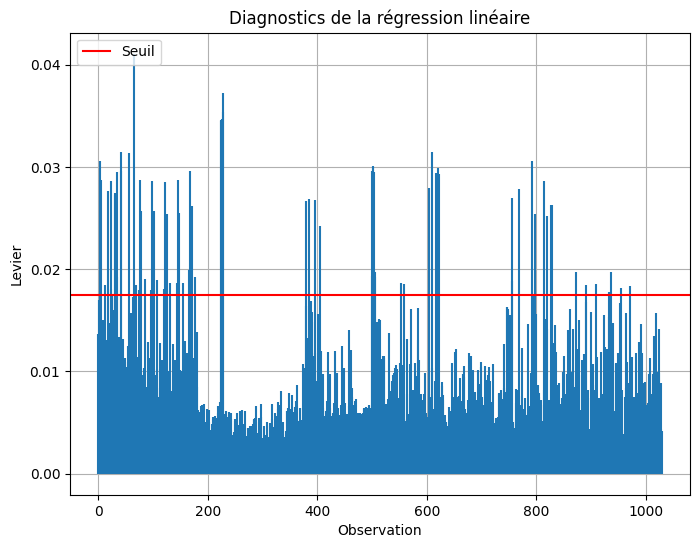

In [18]:
# diagnostico da regressao linear

alpha = 0.05
n = data.shape[0]
p = len(var_x)
influence = linreg_sel.get_influence()

#leviers
levier = influence.hat_matrix_diag
seuil_levier = 2*(p+1)/n

plt.subplots(figsize=(8, 6))
plt.vlines(range(n), 0, levier)
plt.axhline(y=seuil_levier, label='Seuil', color='red')
plt.grid()
plt.xlabel('Observation')
plt.ylabel('Levier')
plt.title('Diagnostics de la régression linéaire')
plt.legend(loc='upper left')
plt.show()

In [19]:
print('Observations avec un levier dépassant le seuil :')
np.where(levier > seuil_levier)

Observations avec un levier dépassant le seuil :


(array([  3,   4,   6,  12,  17,  23,  24,  25,  30,  31,  33,  34,  35,
         41,  42,  56,  66,  69,  74,  76,  79,  85,  97,  99, 102, 108,
        120, 122, 125, 131, 143, 145, 148, 154, 166, 168, 171, 176, 224,
        225, 226, 227, 228, 380, 384, 396, 405, 499, 500, 501, 502, 503,
        504, 505, 506, 553, 559, 604, 610, 616, 620, 622, 755, 756, 769,
        792, 795, 797, 798, 814, 820, 827, 828, 873, 891, 908, 932, 936,
        954, 971], dtype=int64),)

In [20]:
print('Valeurs des leviers dépassant le seuil :')
levier[levier > seuil_levier]

Valeurs des leviers dépassant le seuil :


array([0.02871635, 0.03056857, 0.02869414, 0.01842671, 0.02766794,
       0.0180286 , 0.02865927, 0.01759039, 0.02725692, 0.02742621,
       0.02049463, 0.02950571, 0.01922233, 0.02957866, 0.03148095,
       0.03136991, 0.04107638, 0.01843526, 0.01796067, 0.02868749,
       0.02571988, 0.01906802, 0.01795705, 0.02863645, 0.02564958,
       0.01898312, 0.01808101, 0.0285115 , 0.02542347, 0.01868039,
       0.01861998, 0.02871858, 0.02549568, 0.01865042, 0.01989424,
       0.02957798, 0.0261865 , 0.01921352, 0.03449529, 0.03455165,
       0.03471872, 0.03537314, 0.03726435, 0.02670297, 0.02688515,
       0.02681763, 0.024255  , 0.02962658, 0.01934418, 0.0300641 ,
       0.02997122, 0.02954075, 0.01979653, 0.01970128, 0.01924173,
       0.01867137, 0.01859511, 0.02792433, 0.03144848, 0.02937784,
       0.02985903, 0.02927404, 0.01884127, 0.02700756, 0.02786516,
       0.03062071, 0.01748582, 0.01796279, 0.0253738 , 0.0286432 ,
       0.02524553, 0.02629557, 0.02627226, 0.01974667, 0.01847

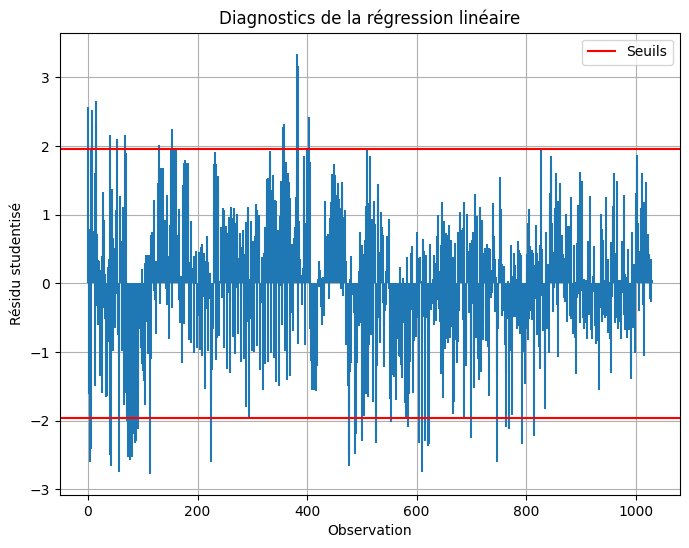

In [21]:
# résidus studentises

rstudent = influence.resid_studentized_external
seuil_rstudent = scy.t.ppf(1-alpha/2, df=n-p-2)

plt.subplots(figsize=(8, 6))
plt.vlines(range(n), 0, rstudent)
plt.axhline(y=seuil_rstudent, label='Seuils', color='red')
plt.axhline(y=-seuil_rstudent, color='red')
plt.grid()
plt.xlabel('Observation')
plt.ylabel('Résidu studentisé')
plt.title('Diagnostics de la régression linéaire')
plt.legend(loc='best')
plt.show()

In [22]:
print('Observations avec un résidu studentisé dépassant les seuils :')
np.where(rstudent > seuil_rstudent)

Observations avec un résidu studentisé dépassant les seuils :


(array([  0,   8,  14,  15,  40,  53,  68, 130, 153, 356, 357, 381, 383,
        400, 404, 828], dtype=int64),)

In [23]:
print('Valeurs des résidus studentisés dépassant les seuils :')
rstudent[rstudent > seuil_rstudent]

Valeurs des résidus studentisés dépassant les seuils :


array([2.57406665, 2.52431936, 2.65708186, 2.34721849, 2.1660238 ,
       2.09995037, 2.15658719, 2.01840455, 2.24248406, 2.27777118,
       2.32485214, 3.34577842, 3.16802703, 1.96918901, 2.42080933,
       1.96673645])

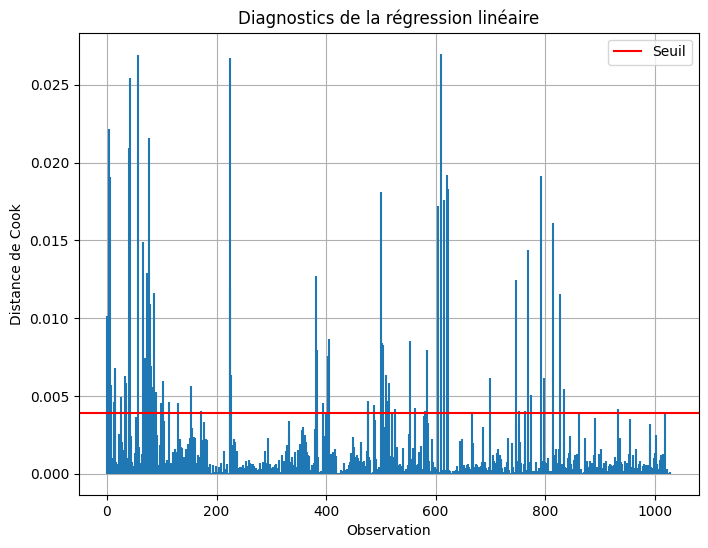

In [24]:
# distance de cook

dcook, pcook = influence.cooks_distance
seuil_dcook = 4/(n-p-1)

plt.subplots(figsize=(8, 6))
plt.vlines(range(n), 0, dcook)
plt.axhline(y=seuil_dcook, label='Seuil', color='red')
plt.grid()
plt.xlabel('Observation')
plt.ylabel('Distance de Cook')
plt.title('Diagnostics de la régression linéaire')
plt.legend(loc='best')
plt.show()

In [25]:
print('Observations avec une distance de Cook dépassant le seuil :')
np.where(dcook > seuil_dcook)

Observations avec une distance de Cook dépassant le seuil :


(array([  0,   2,   3,   4,   6,   8,  12,  14,  15,  26,  33,  35,  40,
         41,  42,  56,  66,  68,  69,  71,  72,  74,  76,  77,  79,  80,
         81,  84,  85,  87,  90,  99, 102, 114, 130, 153, 171, 224, 225,
        226, 381, 383, 395, 404, 405, 476, 477, 488, 501, 502, 504, 509,
        512, 514, 526, 553, 563, 581, 584, 604, 610, 616, 620, 622, 666,
        699, 746, 753, 763, 769, 774, 792, 798, 814, 828, 834, 933],
       dtype=int64),)

In [26]:
print('Valeurs des distances de Cook dépassant le seuil :')
dcook[dcook > seuil_dcook]

Valeurs des distances de Cook dépassant le seuil :


array([0.01015338, 0.0049492 , 0.02214368, 0.00923138, 0.01909663,
       0.00569245, 0.00460714, 0.00679111, 0.00621819, 0.0049503 ,
       0.00630625, 0.00585628, 0.00443577, 0.02094752, 0.02542137,
       0.02692865, 0.01488537, 0.00442831, 0.0074622 , 0.00502832,
       0.00417501, 0.01291665, 0.02158221, 0.00417501, 0.01089283,
       0.00417501, 0.00692283, 0.00556703, 0.01160507, 0.00444936,
       0.00522433, 0.00452148, 0.00594909, 0.00458276, 0.00456012,
       0.00565908, 0.00404083, 0.02669591, 0.01190791, 0.00633383,
       0.01269049, 0.00792072, 0.00451556, 0.0075859 , 0.00863323,
       0.00414018, 0.00469442, 0.00442989, 0.0180867 , 0.0084282 ,
       0.0083007 , 0.00635993, 0.00464307, 0.00583491, 0.00413317,
       0.00852834, 0.00424866, 0.00405439, 0.00795283, 0.01723643,
       0.0269952 , 0.01759342, 0.01917589, 0.01832874, 0.00393491,
       0.00615017, 0.01244374, 0.00405989, 0.00405909, 0.01435015,
       0.00508971, 0.01912242, 0.00616681, 0.01612685, 0.01156

In [27]:
# detectar colinearidade

#calcular VIF - Variance Inflation Factor
X = add_constant(X)

# Calcular o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["variavel"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             variavel          VIF
0               const  6732.373793
1              cement     7.488657
2  blast_furnace_slag     7.276529
3             fly_ash     6.171455
4               water     7.004663
5    superplasticizer     2.965297
6    coarse_aggregate     5.076044
7      fine_aggregate     7.005346
8                 age     1.118357


In [28]:
# prevision du compressive strength

#testes:
#540.0	0.0	0.0	162.0	2.5	1040.0	676.0	28
#142.5	0.0	228.0	0.0	932.0	594.0	270
# 142.5	0.0	228.0	0.0	932.0	594.0	365	41.05278


# Justificar com o R2 : o R^2 é muito baixo

a_prevoir = pd.DataFrame({'const': [1], 'cement': [540], 'blast_furnace_slag': [0], 'fly_ash': [0], 
                          'water': [162], 'superplasticizer':[2.5],'coarse_aggregate':[1040],'fine_aggregate':[676], 'age': [28]})
prev = linreg_sel.predict(a_prevoir)[0]
print('Prévision :', round(prev, ndigits=2))


Prévision : 53.47


In [48]:
data = data.drop(['residu', 'cluster_kmeans','compressive_strength_ajust'], axis=1)
data.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


*Question 3.2*

In [61]:
# retirar as variaveis q tem p-valuer maior que 5%
# retirar variaveis com alta correlação
var_x = ['cement','blast_furnace_slag','water','superplasticizer','fine_aggregate','fly_ash', 'age']
X = data[var_x]

# pd.options.display.float_format = '{:.6f}'.format 

linreg_sel = sm.OLS(y, X).fit()

print(linreg_sel.summary())

                                  OLS Regression Results                                 
Dep. Variable:     compressive_strength   R-squared (uncentered):                   0.931
Model:                              OLS   Adj. R-squared (uncentered):              0.930
Method:                   Least Squares   F-statistic:                              1958.
Date:                  Thu, 14 Nov 2024   Prob (F-statistic):                        0.00
Time:                          20:38:04   Log-Likelihood:                         -3875.1
No. Observations:                  1030   AIC:                                      7764.
Df Residuals:                      1023   BIC:                                      7799.
Df Model:                             7                                                  
Covariance Type:              nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------

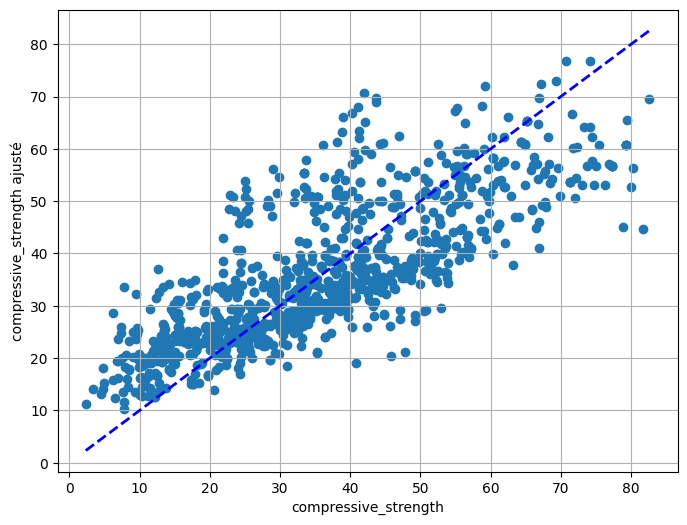

In [62]:
# analyse de l'ajustement
data['compressive_strength_ajust'] = linreg_sel.fittedvalues

x_bissec = np.linspace(data['compressive_strength'].min(), data['compressive_strength'].max(), 2)

plt.subplots(figsize=(8, 6))
plt.scatter(data['compressive_strength'], data['compressive_strength_ajust'])
plt.plot(x_bissec, x_bissec, linestyle='dashed', lw=2, color='blue')
plt.grid()
plt.xlabel('compressive_strength')
plt.ylabel('compressive_strength ajusté')
plt.show()

Moyenne des résidus : 0.04
Variance des résidus : 108.58


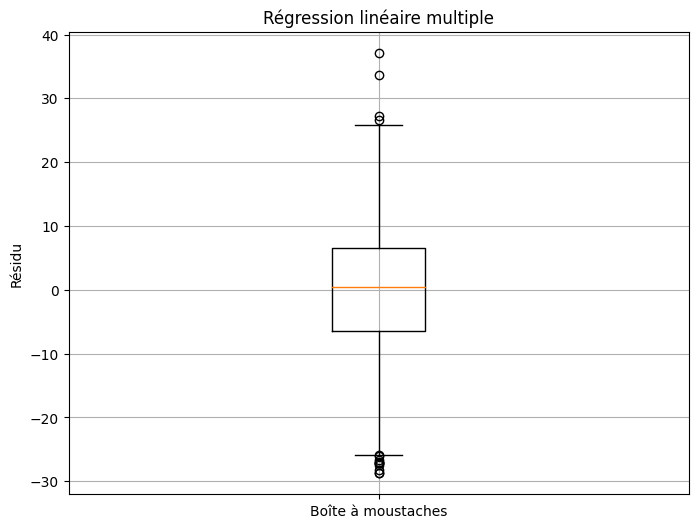

In [63]:
data['residu'] = linreg_sel.resid

moy_res = data.residu.mean()
print('Moyenne des résidus :', round(moy_res, ndigits=2))

var_res = data.residu.var()
print('Variance des résidus :', round(var_res, ndigits=2))

plt.subplots(figsize=(8, 6))
plt.boxplot(data['residu'], labels=['Boîte à moustaches'])
plt.grid()
plt.ylabel('Résidu')
plt.title('Régression linéaire multiple')
plt.show()

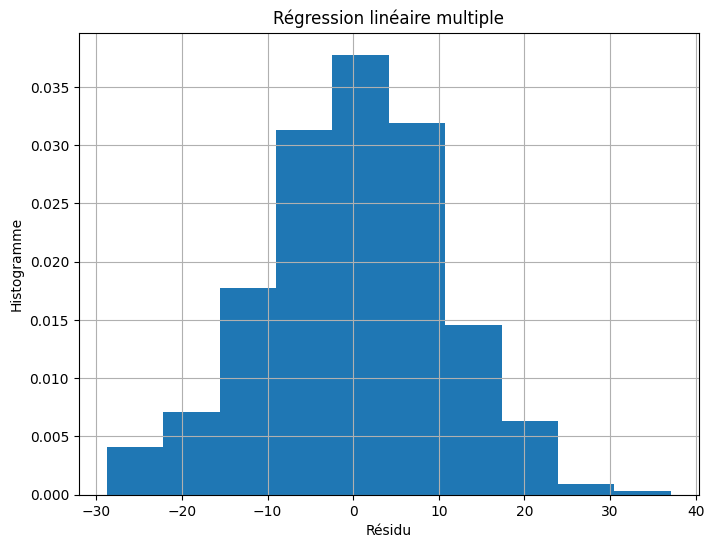

In [64]:
plt.subplots(figsize=(8, 6))
plt.hist(data['residu'], density=True)
plt.grid()
plt.xlabel('Résidu')
plt.ylabel('Histogramme')
plt.title('Régression linéaire multiple')
plt.show()

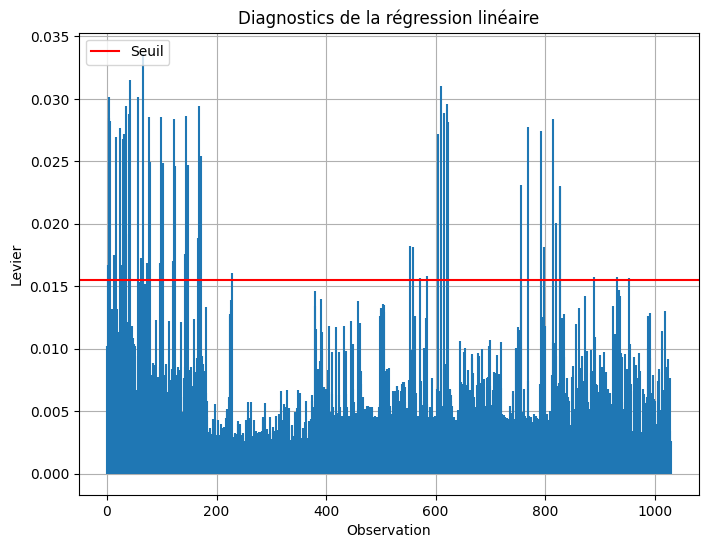

In [65]:
# diagnostico da regressao linear

alpha = 0.05
n = data.shape[0]
p = len(var_x)
influence = linreg_sel.get_influence()

#leviers
levier = influence.hat_matrix_diag
seuil_levier = 2*(p+1)/n

plt.subplots(figsize=(8, 6))
plt.vlines(range(n), 0, levier)
plt.axhline(y=seuil_levier, label='Seuil', color='red')
plt.grid()
plt.xlabel('Observation')
plt.ylabel('Levier')
plt.title('Diagnostics de la régression linéaire')
plt.legend(loc='upper left')
plt.show()

In [66]:
print('Observations avec un levier dépassant le seuil :')
np.where(levier > seuil_levier)

Observations avec un levier dépassant le seuil :


(array([  2,   3,   4,   6,  12,  17,  24,  25,  26,  30,  31,  33,  34,
         35,  41,  42,  56,  63,  65,  66,  74,  76,  79,  97,  99, 102,
        120, 122, 125, 143, 145, 148, 166, 168, 171, 228, 553, 559, 571,
        584, 604, 610, 616, 620, 622, 756, 769, 792, 798, 814, 820, 827,
        828, 890, 932, 953], dtype=int64),)

In [67]:
print('Valeurs des leviers dépassant le seuil :')
levier[levier > seuil_levier]

Valeurs des leviers dépassant le seuil :


array([0.01672614, 0.02850514, 0.0301485 , 0.02824459, 0.01751395,
       0.0269869 , 0.02768183, 0.01647295, 0.01671117, 0.02681533,
       0.02716712, 0.01913448, 0.02944076, 0.01920931, 0.02880179,
       0.03147947, 0.03017674, 0.01724957, 0.01558156, 0.03361672,
       0.01687435, 0.02856677, 0.02492016, 0.01687245, 0.0285158 ,
       0.02485057, 0.01700512, 0.02839086, 0.02462785, 0.01755482,
       0.02859708, 0.0247037 , 0.0188411 , 0.02945401, 0.02539768,
       0.01603933, 0.01825603, 0.01815796, 0.0157004 , 0.01581966,
       0.02719498, 0.03104457, 0.02886311, 0.02957593, 0.02814588,
       0.02309123, 0.02774189, 0.02742439, 0.01810743, 0.02836399,
       0.02003497, 0.02298023, 0.02300188, 0.01572961, 0.01570685,
       0.01562983])

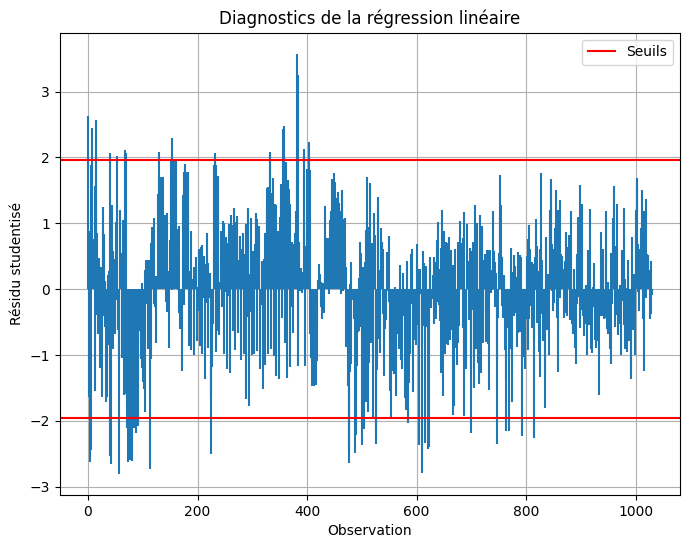

In [68]:
# résidus studentises

rstudent = influence.resid_studentized_external
seuil_rstudent = scy.t.ppf(1-alpha/2, df=n-p-2)

plt.subplots(figsize=(8, 6))
plt.vlines(range(n), 0, rstudent)
plt.axhline(y=seuil_rstudent, label='Seuils', color='red')
plt.axhline(y=-seuil_rstudent, color='red')
plt.grid()
plt.xlabel('Observation')
plt.ylabel('Résidu studentisé')
plt.title('Diagnostics de la régression linéaire')
plt.legend(loc='best')
plt.show()

In [69]:
print('Observations avec un résidu studentisé dépassant les seuils :')
np.where(rstudent > seuil_rstudent)

Observations avec un résidu studentisé dépassant les seuils :


(array([  0,   8,  14,  15,  40,  53,  68,  69, 130, 152, 153, 155, 157,
        160, 232, 332, 333, 356, 357, 358, 381, 383, 395, 404], dtype=int64),)

In [70]:
print('Valeurs des résidus studentisés dépassant les seuils :')
rstudent[rstudent > seuil_rstudent]

Valeurs des résidus studentisés dépassant les seuils :


array([2.62460355, 2.44852373, 2.56883481, 2.23972843, 2.07141169,
       2.017361  , 2.10581441, 2.06068507, 2.0785947 , 1.97011035,
       2.30244773, 1.97011035, 1.97011035, 1.97011035, 2.06475931,
       1.96967106, 2.07649814, 2.43033023, 2.47816259, 2.00784671,
       3.57457842, 3.24589127, 2.12209019, 2.23424683])

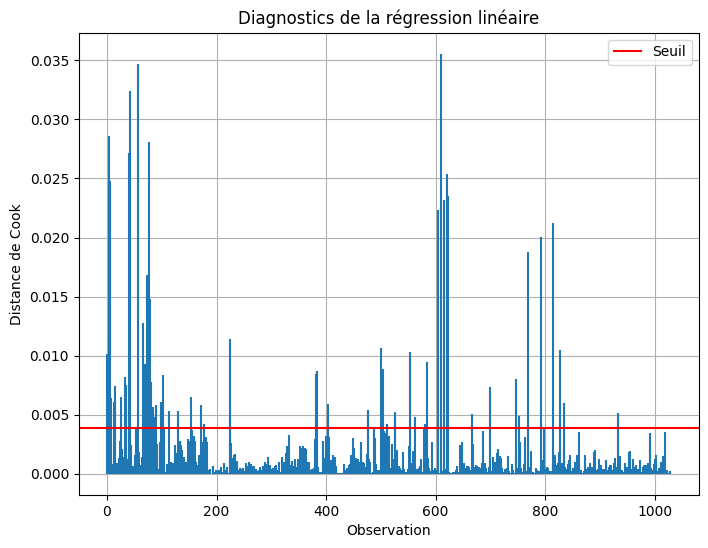

In [71]:
# distance de cook

dcook, pcook = influence.cooks_distance
seuil_dcook = 4/(n-p-1)

plt.subplots(figsize=(8, 6))
plt.vlines(range(n), 0, dcook)

plt.axhline(y=seuil_dcook, label='Seuil', color='red')
plt.grid()
plt.xlabel('Observation')
plt.ylabel('Distance de Cook')
plt.title('Diagnostics de la régression linéaire')
plt.legend(loc='best')
plt.show()

In [72]:
print('Observations avec une distance de Cook dépassant le seuil :')
np.where(dcook > seuil_dcook)

Observations avec une distance de Cook dépassant le seuil :


(array([  0,   2,   3,   4,   6,   8,  12,  14,  15,  26,  33,  35,  40,
         41,  42,  56,  66,  68,  69,  72,  74,  76,  77,  79,  80,  81,
         84,  85,  87,  90,  99, 102, 104, 114, 130, 153, 171, 178, 224,
        225, 381, 382, 383, 404, 476, 477, 501, 502, 504, 512, 525, 526,
        553, 563, 578, 581, 584, 604, 610, 616, 620, 622, 666, 699, 746,
        753, 769, 792, 814, 828, 834, 933], dtype=int64),)

In [73]:
print('Valeurs des distances de Cook dépassant le seuil :')
dcook[dcook > seuil_dcook]

Valeurs des distances de Cook dépassant le seuil :


array([0.01012648, 0.00645382, 0.02862964, 0.01150671, 0.02480103,
       0.00641877, 0.00603799, 0.00738951, 0.0062543 , 0.00646397,
       0.00818247, 0.00749875, 0.00456871, 0.02716788, 0.03240863,
       0.03468116, 0.01276762, 0.0053193 , 0.0093246 , 0.00482722,
       0.01684278, 0.02812475, 0.00482722, 0.01477241, 0.00482722,
       0.00773021, 0.00568934, 0.00483247, 0.00448639, 0.00585116,
       0.0060841 , 0.00833461, 0.0039363 , 0.00535008, 0.00527924,
       0.0064775 , 0.00580041, 0.00422921, 0.01140984, 0.00501696,
       0.0084328 , 0.00451181, 0.00871658, 0.00592829, 0.0047637 ,
       0.00540446, 0.01065693, 0.0051289 , 0.00885793, 0.00423792,
       0.00465026, 0.00526699, 0.01028235, 0.00479688, 0.00396081,
       0.00421817, 0.00942848, 0.02230827, 0.03556536, 0.02321528,
       0.02538881, 0.02355473, 0.00507022, 0.00738317, 0.00801615,
       0.00490221, 0.018793  , 0.02006523, 0.02125451, 0.01050613,
       0.0059585 , 0.00518312])

In [74]:
# detectar colinearidade

#calcular VIF - Variance Inflation Factor
X = add_constant(X)

# Calcular o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["variavel"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             variavel         VIF
0               const  714.432002
1              cement    2.960884
2  blast_furnace_slag    2.677433
3               water    2.282882
4    superplasticizer    2.595102
5      fine_aggregate    2.186240
6             fly_ash    3.194798
7                 age    1.115823


In [ ]:
# prevision du compressive strength

#testes:
#540.0	0.0	0.0	162.0	2.5	1040.0	676.0	28
#142.5	0.0	228.0	0.0	932.0	594.0	270
# 142.5	0.0	228.0	0.0	932.0	594.0	365	41.05278


# Justificar com o R2 : o R^2 é muito baixo



a_prevoir = pd.DataFrame({'cement': [540], 'blast_furnace_slag': [0], 'water': [162], 
                          'superplasticizer': [2.5], 'fine_aggregate': [676], 'fly_ash': [0], 'age': [28]})
a_prevoir = sm.add_constant(a_prevoir)  # Adiciona a constante ao DataFrame de previsão

# Previsão
prev = linreg_sel.predict(a_prevoir)[0]
print('Prévision :', round(prev, ndigits=2))

Prévision : 52.78


*Question 3.3*

In [92]:
# Calcul des AIC e BIC
def AIC_BIC_linreg(X, y, features):
    linreg_model = OLS(y, X[list(features)])
    linreg = linreg_model.fit()
    AIC = linreg.aic
    BIC = linreg.bic
    return {'model':linreg, 'AIC':AIC, 'BIC':BIC}

#  prececure backward
def linreg_backward_predictors(X, y, predictors, crit='BIC', verbose=True):
    results = []
    
    for combi in itertools.combinations(predictors, len(predictors)-1):
        results.append(AIC_BIC_linreg(X=X, y=y, features=list(combi)+['const']))
    models = pd.DataFrame(results)
    
    if crit == 'AIC':
        best_model = models.loc[models['AIC'].argmin()]
    else:
        best_model = models.loc[models['BIC'].argmin()]
    
    if verbose == True:
        print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:', best_model['model'].aic, 'BIC:', best_model['model'].bic)
    
    return best_model

def linreg_backward_proc(X, y, crit='BIC', verbose=True):
    backward_models = pd.DataFrame(columns=['AIC', 'BIC', 'model'])
    predictors = list(X.columns.difference(['const']))
    
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        backward_result = linreg_backward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        if i > 1:
            if backward_result[crit] > backward_model_before:
                break
        backward_models.loc[i] = backward_result
        predictors = backward_models.loc[i]['model'].model.exog_names
        backward_model_before = backward_models.loc[i][crit]
        predictors = [k for k in predictors if k != 'const']
    
    return(backward_models['model'][len(backward_models['model'])])

# precedure forward
def linreg_forward_predictors(X, y, predictors, crit='BIC', verbose=True):
    results=[]
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]

    for p in remaining_predictors:
        results.append(AIC_BIC_linreg(X=X, y=y, features=predictors+[p]+['const']))
    models = pd.DataFrame(results)

    if crit == 'AIC':
        best_model = models.loc[models['AIC'].argmin()]
    else:
        best_model = models.loc[models['BIC'].argmin()]
    
    if verbose == True:
        print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:', best_model['model'].aic, 'BIC:', best_model['model'].bic)
    
    return best_model

def linreg_forward_proc(X, y, crit='BIC', verbose=True):
    forward_models = pd.DataFrame(columns=['AIC', 'BIC', 'model'])
    predictors = []
    
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        forward_result = linreg_forward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        if i > 1:
            if forward_result[crit] > forward_model_before:
                break
        forward_models.loc[i] = forward_result
        predictors = forward_models.loc[i]['model'].model.exog_names
        forward_model_before = forward_models.loc[i][crit]
        predictors = [k for k in predictors if k != 'const']

    return(forward_models['model'][len(forward_models['model'])])

# procedure stepwise
def linreg_stepwise_proc(X, y, crit='BIC', verbose=True):
    stepwise_models = pd.DataFrame(columns=['AIC', 'BIC', 'model'])
    predictors = []
    stepwise_model_before = AIC_BIC_linreg(X, y, predictors+['const'])[crit]
    
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        forward_result = linreg_forward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        stepwise_models.loc[i] = forward_result
        predictors = stepwise_models.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        backward_result = linreg_backward_predictors(X=X, y=y, predictors=predictors, crit=crit, verbose=verbose)
        if backward_result[crit]< forward_result[crit]:
            stepwise_models.loc[i] = backward_result
            predictors = stepwise_models.loc[i]['model'].model.exog_names
            stepwise_model_before = stepwise_models.loc[i][crit]
            predictors = [k for k in predictors if k != 'const']
        if stepwise_models.loc[i][crit]> stepwise_model_before:
            break
        else:
            stepwise_model_before = stepwise_models.loc[i][crit]
        
    return(stepwise_models['model'][len(stepwise_models['model'])])

# metodo backward
linreg_backward = linreg_backward_proc(add_constant(X), y, crit='BIC', verbose=True)

Selected predictors: ['age', 'blast_furnace_slag', 'cement', 'fly_ash', 'superplasticizer', 'water', 'const'] AIC: 7756.046536118118 BIC: 7790.607734686683
Selected predictors: ['age', 'blast_furnace_slag', 'cement', 'fly_ash', 'water', 'const'] AIC: 7762.053772352654 BIC: 7791.677656839996


In [93]:
#metodo forward
linreg_forward = linreg_forward_proc(add_constant(X), y, crit='BIC', verbose=True)

Selected predictors: ['cement', 'const'] AIC: 8433.108416315361 BIC: 8442.983044477809
Selected predictors: ['cement', 'superplasticizer', 'const'] AIC: 8283.04679779334 BIC: 8297.85874003701
Selected predictors: ['cement', 'superplasticizer', 'age', 'const'] AIC: 8053.640188838439 BIC: 8073.389445163333
Selected predictors: ['cement', 'superplasticizer', 'age', 'blast_furnace_slag', 'const'] AIC: 7907.759711067591 BIC: 7932.446281473709
Selected predictors: ['cement', 'superplasticizer', 'age', 'blast_furnace_slag', 'water', 'const'] AIC: 7830.550700289181 BIC: 7860.174584776523
Selected predictors: ['cement', 'superplasticizer', 'age', 'blast_furnace_slag', 'water', 'fly_ash', 'const'] AIC: 7756.046536118118 BIC: 7790.607734686683
Selected predictors: ['cement', 'superplasticizer', 'age', 'blast_furnace_slag', 'water', 'fly_ash', 'fine_aggregate', 'const'] AIC: 7757.773356071846 BIC: 7797.271868721636


In [94]:
# metodo stepwise
linreg_stepwise = linreg_stepwise_proc(add_constant(X), y, crit='BIC', verbose=True)

# o resultado com menor BIC é o melhor

# discutir depois sobre o fly_ash ser relevante para a compressive streght pelo BIC
# mas ser irrelevante pelo p-value 

Selected predictors: ['cement', 'const'] AIC: 8433.108416315361 BIC: 8442.983044477809
Selected predictors: ['const'] AIC: 8724.455280489605 BIC: 8729.392594570829
Selected predictors: ['cement', 'superplasticizer', 'const'] AIC: 8283.04679779334 BIC: 8297.85874003701
Selected predictors: ['cement', 'const'] AIC: 8433.108416315361 BIC: 8442.983044477809
Selected predictors: ['cement', 'superplasticizer', 'age', 'const'] AIC: 8053.640188838439 BIC: 8073.389445163333
Selected predictors: ['cement', 'superplasticizer', 'const'] AIC: 8283.04679779334 BIC: 8297.85874003701
Selected predictors: ['cement', 'superplasticizer', 'age', 'blast_furnace_slag', 'const'] AIC: 7907.759711067591 BIC: 7932.446281473709
Selected predictors: ['cement', 'superplasticizer', 'age', 'const'] AIC: 8053.640188838439 BIC: 8073.389445163333
Selected predictors: ['cement', 'superplasticizer', 'age', 'blast_furnace_slag', 'water', 'const'] AIC: 7830.550700289181 BIC: 7860.174584776523
Selected predictors: ['cement'

*Question 3.4*

In [95]:
#On sépare l'échantillon en 2 : on estime la régression sur 80% 
# de l'échantillon (échantillon d'apprentissage) et on évalue la 
# prédiction sur les 20% restant (échantillon test).

train = np.random.binomial(n=1, p=0.2, size=data.shape[0])

X_train = X[train == 0]
y_train = y[train == 0]

X_test = X[train == 1]
y_test = y[train == 1]

reg = LinearRegression().fit(X_train, y_train)

RMSE = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print('RMSE :', round(RMSE, ndigits=2))

MAPE = mean_absolute_percentage_error(y_test, reg.predict(X_test)) * 100
print('MAPE :', round(MAPE, ndigits=2))

RMSE : 10.86
MAPE : 27.4


In [96]:
K = 5

bloc = np.random.randint(low=0, high=K, size=data.shape[0])

n_test = np.empty(K, dtype = int)
RMSE = np.empty(K, dtype = float)
MAPE = np.empty(K, dtype = float)

for i in range(K):
  
  n_test[i] = X[bloc == i].shape[0]

  X_train = X[bloc != i]
  y_train = y[bloc != i]

  X_test = X[bloc == i]
  y_test = y[bloc == i]

  reg = LinearRegression().fit(X_train, y_train)

  RMSE[i] = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
  MAPE[i] = mean_absolute_percentage_error(y_test, reg.predict(X_test)) * 100

RMSE_CV = np.sum(n_test * RMSE / np.sum(n_test))
print('RMSE CV :', round(RMSE_CV, ndigits=2))

MAPE_CV = np.sum(n_test * MAPE / np.sum(n_test))
print('MAPE CV :', round(MAPE_CV, ndigits=2))

RMSE CV : 10.43
MAPE CV : 31.7


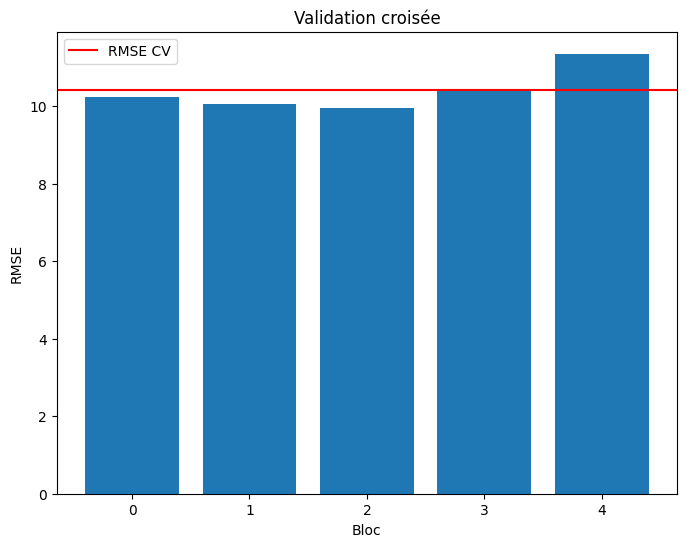

In [97]:
plt.subplots(figsize=(8, 6))
plt.bar(range(K), RMSE)
plt.axhline(y=RMSE_CV, label='RMSE CV', color='red')
#plt.grid()
plt.xlabel('Bloc')
plt.ylabel('RMSE')
plt.title('Validation croisée')
plt.legend(loc='best')
plt.show()

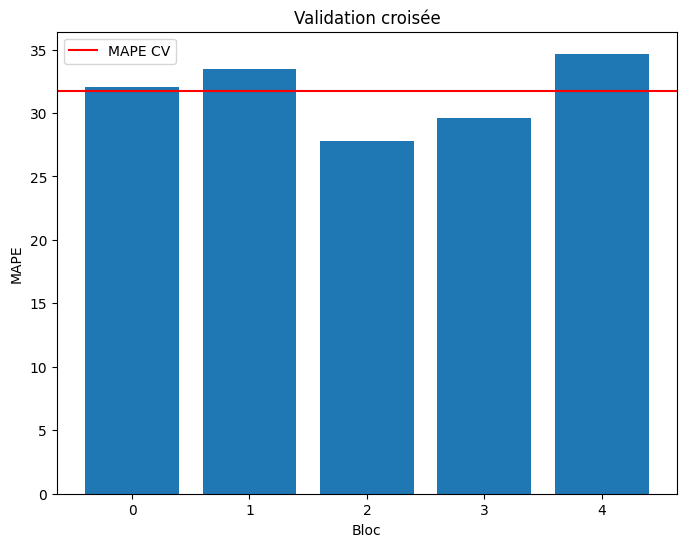

In [98]:
plt.subplots(figsize=(8, 6))
plt.bar(range(K), MAPE)
plt.axhline(y=MAPE_CV, label='MAPE CV', color='red')
#plt.grid()
plt.xlabel('Bloc')
plt.ylabel('MAPE')
plt.title('Validation croisée')
plt.legend(loc='best')
plt.show()

*Question 3.5*

In [99]:
# exercice 3.5

# primeira divisao

train = np.random.binomial(n=1, p=0.2, size=data.shape[0])

X_train = X[train == 0]
y_train = y[train == 0]

X_test = X[train == 1]
y_test = y[train == 1]

reg = LinearRegression().fit(X_train, y_train)

RMSE = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print('RMSE :', round(RMSE, ndigits=2))

MAPE = mean_absolute_percentage_error(y_test, reg.predict(X_test)) * 100
print('MAPE :', round(MAPE, ndigits=2))

RMSE : 10.66
MAPE : 35.3


In [100]:
K = 5

bloc = np.random.randint(low=0, high=K, size=data.shape[0])

n_test = np.empty(K, dtype = int)
RMSE = np.empty(K, dtype = float)
MAPE = np.empty(K, dtype = float)

for i in range(K):
  
  n_test[i] = X[bloc == i].shape[0]

  X_train = X[bloc != i]
  y_train = y[bloc != i]

  X_test = X[bloc == i]
  y_test = y[bloc == i]

  reg = LinearRegression().fit(X_train, y_train)

  RMSE[i] = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
  MAPE[i] = mean_absolute_percentage_error(y_test, reg.predict(X_test)) * 100

RMSE_CV = np.sum(n_test * RMSE / np.sum(n_test))
print('RMSE CV :', round(RMSE_CV, ndigits=2))

MAPE_CV = np.sum(n_test * MAPE / np.sum(n_test))
print('MAPE CV :', round(MAPE_CV, ndigits=2))

RMSE CV : 10.54
MAPE CV : 31.85


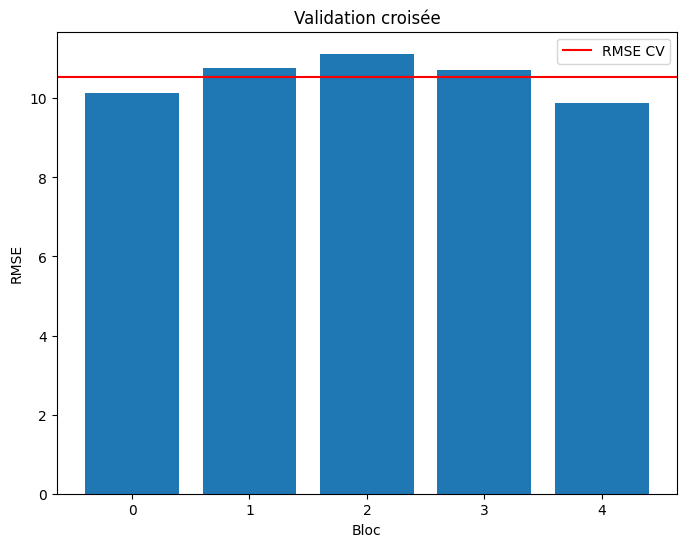

In [101]:
plt.subplots(figsize=(8, 6))
plt.bar(range(K), RMSE)
plt.axhline(y=RMSE_CV, label='RMSE CV', color='red')
#plt.grid()
plt.xlabel('Bloc')
plt.ylabel('RMSE')
plt.title('Validation croisée')
plt.legend(loc='best')
plt.show()

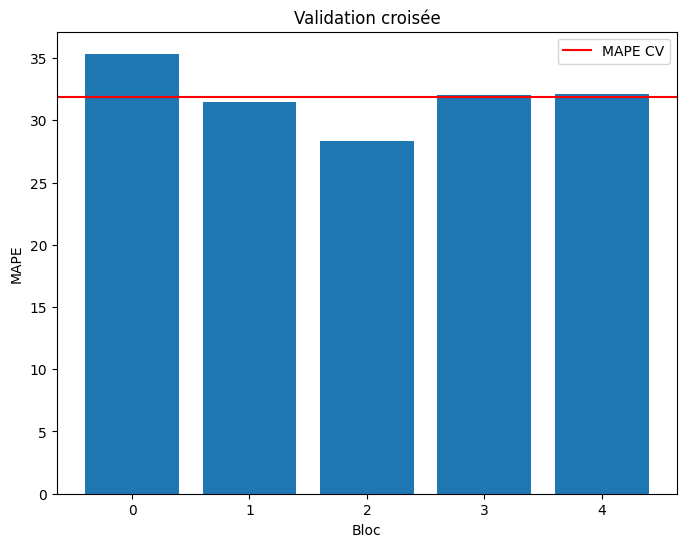

In [102]:
plt.subplots(figsize=(8, 6))
plt.bar(range(K), MAPE)
plt.axhline(y=MAPE_CV, label='MAPE CV', color='red')
#plt.grid()
plt.xlabel('Bloc')
plt.ylabel('MAPE')
plt.title('Validation croisée')
plt.legend(loc='best')
plt.show()

In [103]:
# segunda divisão

# Divisão dos dados, mantendo 80% para treinamento e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


reg = LinearRegression().fit(X_train, y_train)

RMSE = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print('RMSE :', round(RMSE, ndigits=2))

MAPE = mean_absolute_percentage_error(y_test, reg.predict(X_test)) * 100
print('MAPE :', round(MAPE, ndigits=2))

RMSE : 9.82
MAPE : 29.49


In [104]:
K = 5

bloc = np.random.randint(low=0, high=K, size=data.shape[0])

n_test = np.empty(K, dtype = int)
RMSE = np.empty(K, dtype = float)
MAPE = np.empty(K, dtype = float)

for i in range(K):
  
  n_test[i] = X[bloc == i].shape[0]

  X_train = X[bloc != i]
  y_train = y[bloc != i]

  X_test = X[bloc == i]
  y_test = y[bloc == i]

  reg = LinearRegression().fit(X_train, y_train)

  RMSE[i] = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
  MAPE[i] = mean_absolute_percentage_error(y_test, reg.predict(X_test)) * 100

RMSE_CV = np.sum(n_test * RMSE / np.sum(n_test))
print('RMSE CV :', round(RMSE_CV, ndigits=2))

RMSE CV : 10.46


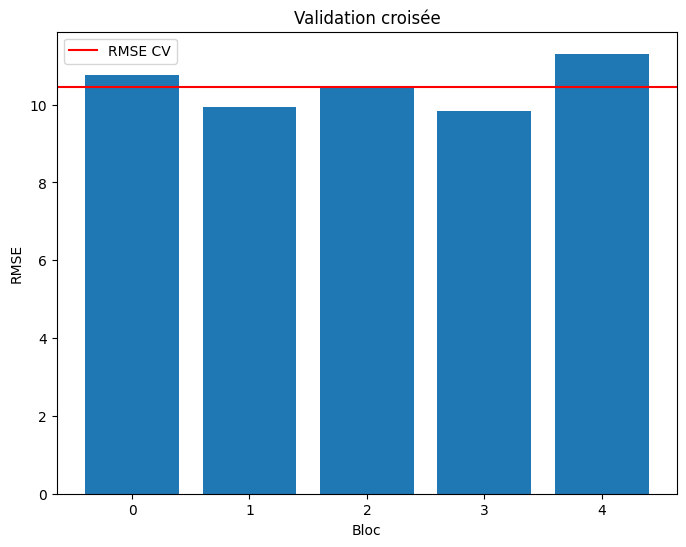

In [105]:
plt.subplots(figsize=(8, 6))
plt.bar(range(K), RMSE)
plt.axhline(y=RMSE_CV, label='RMSE CV', color='red')
#plt.grid()
plt.xlabel('Bloc')
plt.ylabel('RMSE')
plt.title('Validation croisée')
plt.legend(loc='best')
plt.show()

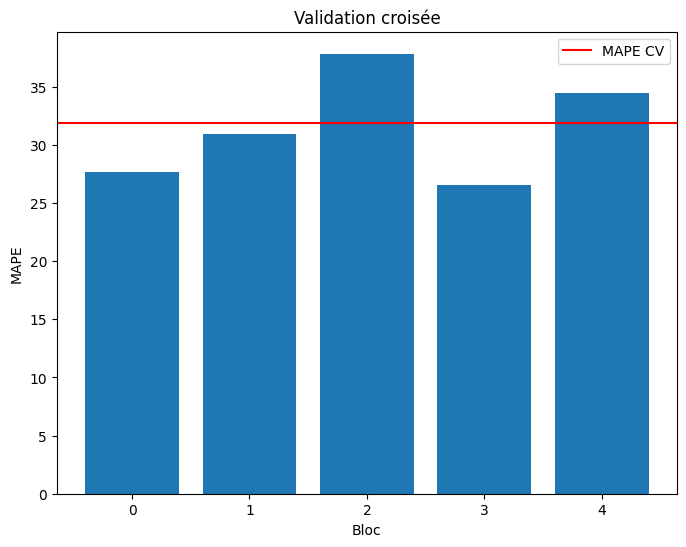

In [106]:
plt.subplots(figsize=(8, 6))
plt.bar(range(K), MAPE)
plt.axhline(y=MAPE_CV, label='MAPE CV', color='red')
#plt.grid()
plt.xlabel('Bloc')
plt.ylabel('MAPE')
plt.title('Validation croisée')
plt.legend(loc='best')
plt.show()